# Outlier Detection with CIFAR10 using Alibi-Detect

This examples show a Cifar10 prediction service with outlier detection. We ignore the prediction from our model if we suspect the input is an outlier.



## Prerequisites

This notebooks needs to be run in the `tempo-examples` conda environment defined below. Create from project root folder:

```bash
conda env create --name tempo-examples --file conda/tempo-examples.yaml
```

In [1]:
!cat ../../../conda/tempo-examples.yaml

name: tempo
channels:
  - defaults
dependencies:
  - pip=21.0.1=py37h06a4308_0
  - python=3.7.9=h7579374_0
  - pip:
      - opencv-python-headless
      - conda-pack
      - jupyter
      - mlops-tempo
      - alibi
      - alibi-detect==0.5.1
      - dill
      - mlserver==0.3.1.dev7
      - xgboost
      - ansible
      - openshift


In [2]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [3]:
import cloudpickle
import tensorflow as tf
import matplotlib.pyplot as plt

from tempo.serve.metadata import ModelFramework, RuntimeOptions
from tempo.serve.model import Model
from tempo.serve.pipeline import PipelineModels
from tempo.seldon.docker import SeldonDockerRuntime
from tempo.kfserving.protocol import KFServingV2Protocol, KFServingV1Protocol
from tempo.serve.utils import pipeline, predictmethod, model
from tempo.seldon.k8s import SeldonKubernetesRuntime
from tempo.kfserving.k8s import KFServingKubernetesRuntime
from tempo.serve.metadata import ModelFramework, KubernetesOptions
from tempo.serve.loader import save, upload, download
from alibi.utils.wrappers import ArgmaxTransformer
from typing import Any

import numpy as np
import os 
import pprint
import json

OUTLIER_FOLDER = os.getcwd()+"/artifacts/cifar10_outlier"
MODEL_FOLDER = os.getcwd()+"/artifacts/cifar10_model"
SVC_FOLDER = os.getcwd()+"/artifacts/svc"

tf.get_logger().setLevel('INFO')

import logging
logging.basicConfig(level=logging.ERROR)

In [4]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from tqdm import tqdm

from alibi_detect.models.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.saving import load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

In [5]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):  # pylint: disable=arguments-differ,method-hidden
        if isinstance(
            obj,
            (
                np.int_,
                np.intc,
                np.intp,
                np.int8,
                np.int16,
                np.int32,
                np.int64,
                np.uint8,
                np.uint16,
                np.uint32,
                np.uint64,
            ),
        ):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


In [6]:
def show_image(X):
    plt.imshow(X.reshape(32, 32, 3))
    plt.axis('off')
    plt.show()

In [7]:
train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [8]:
%%writefile rclone.conf
[gs]
type = google cloud storage
anonymous = true

Writing rclone.conf


In [9]:
import os
from tempo.conf import settings
settings.rclone_cfg = os.getcwd() + "/rclone.conf"

In [10]:
load_pretrained = True
if load_pretrained:  # load pre-trained detector
    !rclone --config ./rclone.conf copy gs://seldon-models/tempo/cifar10/outlier/cifar10 ./artifacts/cifar10_outlier/cifar10
else:  # define model, initialize, train and save outlier detector

    # define encoder and decoder networks
    latent_dim = 1024
    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(32, 32, 3)),
          Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
      ]
    )

    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(4*4*128),
          Reshape(target_shape=(4, 4, 128)),
          Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
      ]
    )

    # initialize outlier detector
    od = OutlierVAE(
        threshold=.015,  # threshold for outlier score
        encoder_net=encoder_net,  # can also pass VAE model instead
        decoder_net=decoder_net,  # of separate encoder and decoder
        latent_dim=latent_dim
    )

    # train
    od.fit(X_train, epochs=50, verbose=False)

    # save the trained outlier detector
    save_detector(od, filepath)

## Create Tempo Artifacts

In [11]:
runtimeOptions=RuntimeOptions(  
    k8s_options=KubernetesOptions( 
        namespace="production",
        authSecretName="minio-secret"
    )
)


cifar10_model = Model(
    name="resnet32",
    protocol=KFServingV1Protocol(),
    runtime_options=runtimeOptions,
    platform=ModelFramework.Tensorflow,
    uri="gs://seldon-models/tfserving/cifar10/resnet32",
    local_folder=MODEL_FOLDER,
)


@model(
    name="outlier",
    platform=ModelFramework.TempoPipeline,
    protocol=KFServingV2Protocol(),
    runtime_options=runtimeOptions,
    uri="s3://tempo/outlier/cifar10/outlier",
    local_folder=OUTLIER_FOLDER,
)
class OutlierModel(object):
    
    def __init__(self):
        self.loaded = False
        
    def load(self):
        if "MLSERVER_MODELS_DIR" in os.environ:
            models_folder = "/mnt/models"
        else:
            models_folder = OUTLIER_FOLDER
        print(f"Loading from {models_folder}")
        self.od = load_detector(f"{models_folder}/cifar10")
        self.loaded = True
        
    def unload(self):
        self.od = None
        self.loaded = False
        
    @predictmethod
    def outlier(self, payload: np.ndarray) -> dict:
        if not self.loaded:
            self.load()
        od_preds = self.od.predict(payload,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)
        
        return json.loads(json.dumps(od_preds, cls=NumpyEncoder))   

In [12]:
outlier = OutlierModel()

In [13]:
@pipeline(
    name="cifar10-service",
    protocol=KFServingV2Protocol(),
    runtime_options=runtimeOptions,
    uri="s3://tempo/outlier/cifar10/svc",
    local_folder=SVC_FOLDER,
    models=PipelineModels(outlier=outlier, cifar10=cifar10_model)
)
class Cifar10(object):
        
    @predictmethod
    def predict(self, payload: np.ndarray) -> np.ndarray:
        r = self.models.outlier(payload=payload)
        if r["data"]["is_outlier"][0]:
            return np.array([])
        else:
            return self.models.cifar10(payload)

        
svc = Cifar10()

In [14]:
idx = 1
X = X_train[idx:idx+1]
np.random.seed(0) 
X_mask, mask = apply_mask(X.reshape(1, 32, 32, 3),
                                  mask_size=(10,10),
                                  n_masks=1,
                                  channels=[0,1,2],
                                  mask_type='normal',
                                  noise_distr=(0,1),
                                  clip_rng=(0,1))

## Saving Artifacts

In [15]:
import sys
import os
PYTHON_VERSION = f"{sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}"
TEMPO_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))

In [16]:
%%writetemplate artifacts/cifar10_outlier/conda.yaml
name: tempo
channels:
  - defaults
dependencies:
  - python={PYTHON_VERSION}
  - pip:
    - alibi-detect
    - dill
    - opencv-python-headless
    - mlops-tempo @ file://{TEMPO_DIR}
    - mlserver==0.3.1.dev7

In [18]:
!mkdir -p artifacts/svc/

In [19]:
%%writetemplate artifacts/svc/conda.yaml
name: tempo
channels:
  - defaults
dependencies:
  - python={PYTHON_VERSION}
  - pip:
    - dill
    - opencv-python-headless
    - mlops-tempo @ file://{TEMPO_DIR}
    - mlserver==0.3.1.dev7

In [20]:
outlier = OutlierModel()
save(outlier, save_env=True)

INFO:tempo:Saving environment
INFO:tempo:Saving tempo model to /home/rskolasinski/work/tempo/docs/examples/outlier/artifacts/cifar10_outlier/model.pickle
INFO:tempo:Using found conda.yaml
INFO:tempo:Creating conda env with: conda env create --name tempo-af520afe-5d18-4d64-8345-5eccb3b52320 --file /tmp/tmpfjqm_wb7.yml
INFO:tempo:packing conda environment from tempo-af520afe-5d18-4d64-8345-5eccb3b52320


Packing environment at '/home/rskolasinski/miniconda3/envs/tempo-af520afe-5d18-4d64-8345-5eccb3b52320' to '/home/rskolasinski/work/tempo/docs/examples/outlier/artifacts/cifar10_outlier/environment.tar.gz'
[########################################] | 100% Completed |  1min  4.5s


INFO:tempo:Removing conda env with: conda remove --name tempo-af520afe-5d18-4d64-8345-5eccb3b52320 --all --yes


In [21]:
svc = Cifar10()
save(svc, save_env=True)

INFO:tempo:Saving environment
INFO:tempo:Saving tempo model to /home/rskolasinski/work/tempo/docs/examples/outlier/artifacts/svc/model.pickle
INFO:tempo:Using found conda.yaml
INFO:tempo:Creating conda env with: conda env create --name tempo-c2adc6e3-4d06-45f1-b875-3d3477578d32 --file /tmp/tmph4mtbx_a.yml
INFO:tempo:packing conda environment from tempo-c2adc6e3-4d06-45f1-b875-3d3477578d32


Packing environment at '/home/rskolasinski/miniconda3/envs/tempo-c2adc6e3-4d06-45f1-b875-3d3477578d32' to '/home/rskolasinski/work/tempo/docs/examples/outlier/artifacts/svc/environment.tar.gz'
[########################################] | 100% Completed | 13.9s


INFO:tempo:Removing conda env with: conda remove --name tempo-c2adc6e3-4d06-45f1-b875-3d3477578d32 --all --yes


## Test on docker with local pipelines

In [22]:
download(cifar10_model)

INFO:tempo:Downloading gs://seldon-models/tfserving/cifar10/resnet32 to /home/rskolasinski/work/tempo/docs/examples/outlier/artifacts/cifar10_model


## Test Svc on docker

In [23]:
docker_runtime = SeldonDockerRuntime()
docker_runtime.deploy(svc)
docker_runtime.wait_ready(svc)

Run first with our python code running locally and only calling out to the model externally

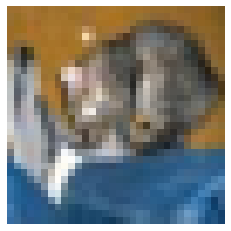

array([[3.92254496e-09, 1.20455460e-11, 2.66010169e-09, 9.99992609e-01,
        2.52212834e-10, 5.40860242e-07, 6.75951833e-06, 4.75118165e-12,
        6.90873403e-09, 1.07275378e-11]])

In [25]:
show_image(X_test[0:1])
svc(payload=X_test[0:1])

Run again completely remotely.

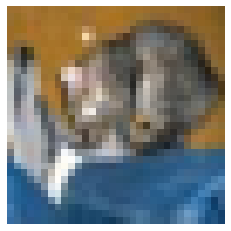

array([[3.92254496e-09, 1.20455460e-11, 2.66010169e-09, 9.99992609e-01,
        2.52212834e-10, 5.40860242e-07, 6.75951833e-06, 4.75118165e-12,
        6.90873403e-09, 1.07275378e-11]])

In [26]:
show_image(X_test[0:1])
svc.remote(payload=X_test[0:1])

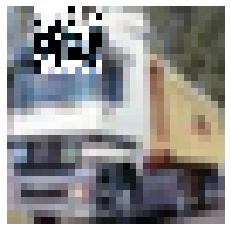

array([], dtype=float64)

In [27]:
show_image(X_mask)
svc.remote(payload=X_mask)

In [28]:
docker_runtime.undeploy(svc)

INFO:tempo:Undeploying cifar10-service
INFO:tempo:Undeploying outlier
INFO:tempo:Undeploying resnet32


## Deploy to Kubernetes

To create a Kubernetes cluster in Kind with all the required install use the ansible playbook defined  below.
Create with

```bash
ansible-playbook ansible/playbooks/default.yaml
```

In [29]:
!cat ../../../ansible/playbooks/default.yaml

---
- name: Install Seldon Core
  hosts: localhost
  roles:
    - kind
    - metallb
    - istio
    - minio
    - seldon_core
  vars:
    kind_cluster_name: seldon
    kind_image_version: kindest/node:v1.18.15
    kind_kubectl_default_namespace: seldon

    istio_version: 1.7.6
    seldon_core_version: v1.7.0

    core_values:
      ambassador:
        enabled: true

      istio:
        enabled: true
        gateway: "seldon-gateway.istio-system.svc.cluster.local"

    seldon_namespaces:
      - default
      - seldon
      - production

    # Verify Install does not work with 1.7.x on k8s 1.18.x
    istio_verify_install: false
    minio_service_type: LoadBalancer


In [30]:
!kubectl create namespace production

Error from server (AlreadyExists): namespaces "production" already exists


In [31]:
!kubectl apply -f ../../../k8s/tempo-pipeline-rbac.yaml -n production

serviceaccount/tempo-pipeline unchanged
role.rbac.authorization.k8s.io/tempo-pipeline unchanged
rolebinding.rbac.authorization.k8s.io/tempo-pipeline-rolebinding unchanged


In [32]:
%%writefile minio-secret.yaml

apiVersion: v1
kind: Secret
metadata:
  name: minio-secret
type: Opaque
stringData:
  AWS_ACCESS_KEY_ID: minioadmin
  AWS_SECRET_ACCESS_KEY: minioadmin
  AWS_ENDPOINT_URL: http://minio.minio-system.svc.cluster.local:9000
  USE_SSL: "false"

Writing minio-secret.yaml


In [33]:
!kubectl apply -f minio-secret.yaml -n production

secret/minio-secret configured


### Uploading artifacts

In [34]:
MINIO_IP=!kubectl get svc minio -n minio-system -o jsonpath='{.status.loadBalancer.ingress[0].ip}'
MINIO_IP=MINIO_IP[0]

In [35]:
%%writetemplate rclone.conf
[gs]
type = google cloud storage
anonymous = true

[s3]
type = s3
provider = minio
env_auth = false
access_key_id = minioadmin
secret_access_key = minioadmin
endpoint = http://{MINIO_IP}:9000

In [36]:
import os
from tempo.conf import settings
settings.rclone_cfg = os.getcwd() + "/rclone.conf"

In [37]:
upload(outlier)
upload(svc)

INFO:tempo:Uploading /home/rskolasinski/work/tempo/docs/examples/outlier/artifacts/cifar10_outlier to s3://tempo/outlier/cifar10/outlier
INFO:tempo:Uploading /home/rskolasinski/work/tempo/docs/examples/outlier/artifacts/svc to s3://tempo/outlier/cifar10/svc


## Deploy to Kubernetes with Seldon

In [38]:
k8s_runtime = SeldonKubernetesRuntime()
k8s_runtime.deploy(svc)
k8s_runtime.wait_ready(svc)

In [39]:
from tempo.utils import tempo_settings
tempo_settings.remote_kubernetes(True)

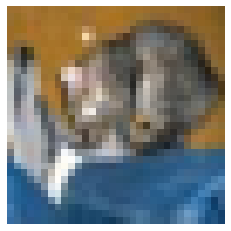

array([[3.92254496e-09, 1.20455460e-11, 2.66010169e-09, 9.99992609e-01,
        2.52212834e-10, 5.40860242e-07, 6.75951833e-06, 4.75118165e-12,
        6.90873403e-09, 1.07275378e-11]])

In [40]:
show_image(X_test[0:1])
svc.remote(payload=X_test[0:1])

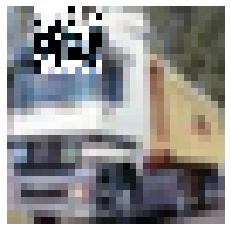

array([], dtype=float64)

In [41]:
show_image(X_mask)
svc.remote(payload=X_mask)

In [42]:
k8s_runtime.undeploy(svc)

INFO:tempo:Undeploying cifar10-service
INFO:tempo:Undeploying outlier
INFO:tempo:Undeploying resnet32
